# Water Quality Monitoring - Exploratory Data Analysis
```L. Patterson & John Fay
Spring 2018```

In this notebook, we examine the two datsets generated from our query of the [Water Quality Data portal](https://www.waterqualitydata.us/portal/) for nutrient data in HUC 03030002 from 1970 trough 2017. The first dataset ([sites.csv](https://www.waterqualitydata.us/Station/search?countrycode=US&statecode=US%3A37&siteType=Lake%2C%20Reservoir%2C%20Impoundment&siteType=Stream&huc=03030002&sampleMedia=Water&characteristicType=Nutrient&minresults=500&startDateLo=01-01-1970&startDateHi=12-31-2017&mimeType=csv&zip=yes&sorted=no)) contains data on the locations where samples were collected, and the second dataset ([results.csv](https://www.waterqualitydata.us/Result/search?countrycode=US&statecode=US%3A37&siteType=Lake%2C%20Reservoir%2C%20Impoundment&siteType=Stream&huc=03030002&sampleMedia=Water&characteristicType=Nutrient&minresults=500&startDateLo=01-01-1970&startDateHi=12-31-2017&mimeType=csv&zip=yes&sorted=no)) contains data on the nutrient samples collected at these sites. 

Our goals here are to upload, prepare (tidy, explore, and merge) these data, and ultimately provide some visualizations that reveal the state of water quality in Jordan lake. We'll begin with the **sites** dataset, examining a few attributes about these data, and the move to the **results** where we filter our data for 'clean' records and tidy it for analysis.

## Prep the workspace

In [1]:
#Import modules
import pandas as pd
import folium
from matplotlib import pyplot as plt

#Enable notebook plotting
%matplotlib inline

## Import and analyzie the water quality *sites* data

### Read the data in as a Pandas dataframe

In [2]:
#Read in the data into the 'sites' dataframe 
sites = pd.read_csv('../data/station.csv',
                   dtype={'HUCEightDigitCode':'str'})

In [3]:
#Display the dimensions of the data frame
sites.shape

(91, 36)

In [4]:
#Display the columns and their data types
sites.dtypes

OrganizationIdentifier                              object
OrganizationFormalName                              object
MonitoringLocationIdentifier                        object
MonitoringLocationName                              object
MonitoringLocationTypeName                          object
MonitoringLocationDescriptionText                   object
HUCEightDigitCode                                   object
DrainageAreaMeasure/MeasureValue                   float64
DrainageAreaMeasure/MeasureUnitCode                 object
ContributingDrainageAreaMeasure/MeasureValue       float64
ContributingDrainageAreaMeasure/MeasureUnitCode    float64
LatitudeMeasure                                    float64
LongitudeMeasure                                   float64
SourceMapScaleNumeric                              float64
HorizontalAccuracyMeasure/MeasureValue             float64
HorizontalAccuracyMeasure/MeasureUnitCode           object
HorizontalCollectionMethodName                      obje

### Exploring the data: Plot the sites
Plot a map to see where water quality data were present from this portal.<br> First we'll plot all the points, then we'll remove sites with small drainage areas and see how many remain...

In [5]:
#Plot all sites--

#Find center coordinates from medians of lat and long columns
medLat = sites['LatitudeMeasure'].median()
medLng = sites['LongitudeMeasure'].median()

#Create the initial map
m = folium.Map(location=[medLat,medLng],
               zoom_start=9,
               tiles='stamenterrain')

#Loop through all features and add them to the map as markers
for row in sites.itertuples():
    #Get info for the record
    lat = row.LatitudeMeasure
    lng = row.LongitudeMeasure
    name = row.MonitoringLocationName
    #Create the marker object, adding them to the map object
    folium.CircleMarker(location=[lat,lng],
                        popup=name,
                        color='red',
                        fill=True,
                        fill_opacity=0.6,
                        radius=3,
                        stroke=False).add_to(m)
    
#Show map
m

In [6]:
#Plot sites with an area > 25 sq mi
sites2 = sites[sites['DrainageAreaMeasure/MeasureValue'] > 25]
sites2.shape

(10, 36)

*Only 10 records!* This seems small. Let's plot these in blue on top of the map created above to see where these 10 sites occur. 

In [7]:
#Loop through all features and add them to the map as markers
for row in sites2.itertuples():
    #Get info for the record
    lat = row.LatitudeMeasure
    lng = row.LongitudeMeasure
    name = row.MonitoringLocationName
    #Create the marker object, adding them to the map object
    folium.CircleMarker(location=[lat,lng],
                        popup=name,
                        color='blue',
                        fill=True,
                        fill_opacity=0.8,
                        radius=3,
                        stroke=False).add_to(m)
    
#Show map
m

We take a closer look at the drainage measurement values and see there are numerous `NA` values. *Clearly, filtering by drainage area will not work*. The main point I want to make here is <mark>**don’t be afraid to play with the data.**</mark>

Let’s replot the site map but now change the popup name to see which site names are located within each branch of Jordan Lake.

In [8]:
#Show the map
m = folium.Map(location=[medLat,medLng],
               zoom_start=9,
               tiles='stamenterrain')

#Loop through all features and add them to the map as markers
for row in sites.itertuples():
    #Get info for the record
    lat = row.LatitudeMeasure
    lng = row.LongitudeMeasure
    name = row.MonitoringLocationIdentifier #<-- Change the field to show as the popup
    #Create the marker object, adding them to the map object
    folium.CircleMarker(location=[lat,lng],
                        popup=name,
                        color='red',
                        fill=True,
                        fill_opacity=0.6,
                        radius=3,
                        stroke=False).add_to(m)
    
#Show map
m

Finally, let's cull some unused columns from our dataset

In [9]:
keepColumns = [0,2,3,7,8,11,12]
sites = sites.iloc[:,keepColumns]
sites.columns

Index(['OrganizationIdentifier', 'MonitoringLocationIdentifier',
       'MonitoringLocationName', 'DrainageAreaMeasure/MeasureValue',
       'DrainageAreaMeasure/MeasureUnitCode', 'LatitudeMeasure',
       'LongitudeMeasure'],
      dtype='object')

---
## Import and explore the water quality *measurement* data
The second dataset downloaded from the [Water Quality Data portal](https://www.waterqualitydata.us/portal/) were the water quality results, stored in the [`result.csv`](https://www.waterqualitydata.us/Result/search?countrycode=US&statecode=US%3A37&siteType=Lake%2C%20Reservoir%2C%20Impoundment&siteType=Stream&huc=03030002&sampleMedia=Water&characteristicType=Nutrient&minresults=500&startDateLo=01-01-1970&startDateHi=12-31-2017&mimeType=csv&zip=yes&sorted=no) file. Let's now import this \[large\] file and tidy it up for analysis.

In [10]:
#Read in the results.csv
results = pd.read_csv('../data/result.csv',
                      low_memory=False      #This is required as it's a large file...
                     )

In [11]:
#Check the dimensions of the dataframe: it's BIG
results.shape

(98590, 63)

### Clean the data by filtering records to only the ones we want
Once we load in the measurements data, we need to do some cleaning. The first step is to filter the data to what we want to use. For example,
* We want to restrict our analysis to streams, filtering out all other media.<br><br>

* We want to make sure we are using routine samples and not extreme event sampling (biased for specific occasions and not for estimating annual average load). So, we'd like to filter out events like storms, droughts, floods, and spring break ups from our analysis.<br><br>

* We determine what type of Nitrogen we want to use. From the literature we found that regulations for Nitrogen include: nitrate, nitrite, ammonia and organic forms. Doing some reading about the WQX standards, you learn that Nitrogen, mixed froms incorporates all of the above forms of nitrogen.<br><br>

*  We also want to make sure we are looking at *total nitrogen*, so we want to make sure the `Results Sample Fraction Text` only includes those with `Total`.

It's handy to know the to what each field in our data refers and what it's values are. An easy way to inspect the latter is with the Pandas `unique()` function which lists the unique values found in a give column...

In [12]:
#List the unique values inthe HydrologicEvent column
results['HydrologicEvent'].unique()

array(['Routine sample', 'Not Determined (historical)', 'Flood', 'Storm',
       'Drought', 'Spring breakup', nan], dtype=object)

In [13]:
#List the unique values inthe CharacteristicName column
results['CharacteristicName'].unique()

array(['Kjeldahl nitrogen', 'Ammonia and ammonium',
       'Inorganic nitrogen (nitrate and nitrite)', 'Organic Nitrogen',
       'Orthophosphate', 'Phosphate-phosphorus', 'Phosphorus',
       'Nitrogen, mixed forms (NH3), (NH4), organic, (NO2) and (NO3)',
       'Nitrate', 'Nitrite', 'Nitrogen', 'Ammonia-nitrogen',
       'Orthophosphate as P', 'Ammonia-nitrogen as N',
       'Phosphate-phosphorus as P', 'Ammonia',
       'Inorganic nitrogen (nitrate and nitrite) as N',
       'Orthophosphate as PO4'], dtype=object)

Filtering in Pandas can be done by creating bitwise (i.e. True/False) "mask" and then combining them with logical operations..

In [14]:
#Step 1 in filtering: creating a mask for each criteria
mediaMask = results['ActivityMediaSubdivisionName'] == "Surface Water"
hydroMask = ~results['HydrologicEvent'].isin(("Storm","Flood","Spring breakup","Drought")) 
charMask = results['CharacteristicName'] == "Nitrogen, mixed forms (NH3), (NH4), organic, (NO2) and (NO3)"
sampFracMask = results['ResultSampleFractionText'] == 'Total'

In [15]:
#Step 2 in filtering: Applying the masks using logical combinations
nitrogen = results[mediaMask & hydroMask & charMask & sampFracMask] 
nitrogen.shape

(4040, 63)

In [16]:
#Check that the filters worked
nitrogen['ActivityMediaSubdivisionName'].unique()

array(['Surface Water'], dtype=object)

In [17]:
nitrogen['HydrologicEvent'].unique()

array(['Routine sample', 'Not Determined (historical)'], dtype=object)

In [18]:
nitrogen['CharacteristicName'].unique()

array(['Nitrogen, mixed forms (NH3), (NH4), organic, (NO2) and (NO3)'], dtype=object)

In [19]:
nitrogen['ResultSampleFractionText'].unique()

array(['Total'], dtype=object)

In [20]:
#Subset columns
usecols=[0,6,21,30,31,32,33,34,58,59,60]
nitrogen = nitrogen.iloc[:,usecols]
nitrogen.columns

Index(['OrganizationIdentifier', 'ActivityStartDate',
       'MonitoringLocationIdentifier', 'ResultDetectionConditionText',
       'CharacteristicName', 'ResultSampleFractionText', 'ResultMeasureValue',
       'ResultMeasure/MeasureUnitCode', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode'],
      dtype='object')

## Detection Limits and Unit Conversion
You may have noticed that many sample sites state “not detected”. This is important data that are not currently being represented. Create a new column and set the value equal to the results, unless it is below the detection limit - in which case set it equal to ½ of the detection limit.

You may also have noted that the total nitrogen was sometimes reported as mg/l or mg/l NO3. We want mg/l. To convert to mg/l, we know the atomic weight of nitrogen is 14.0067 and the molar mass of nitrate anion (NO3) is 62.0049 g/mole. Therefore, to convert between units:
* Nitrate-N (mg/L) = 0.2259 x Nitrate-NO3 (mg/L)
* Nitrate-NO3 (mg/L) = 4.4268 x Nitrate-N (mg/L)

In [21]:
#Set data below the detection limit equal to 1/2 the detection limit

#Set default values to the ResultMeasureValue
nitrogen['TotalN'] = nitrogen['ResultMeasureValue']
nitrogen['TotalN'].mean()

5.2735822913146331

In [22]:
#Create a mask of values that are "Not Detected" and update those valuse
ndMask = nitrogen['ResultDetectionConditionText'] == 'Not Detected'
nitrogen.loc[ndMask,"TotalN"] = nitrogen['DetectionQuantitationLimitMeasure/MeasureValue'] / 2
nitrogen['TotalN'].mean()

4.0751423267326734

In [23]:
#Convert mg/l as NO3 to mg/l as N
no3Mask = nitrogen['DetectionQuantitationLimitMeasure/MeasureUnitCode'] == 'mg/l NO3'
nitrogen.loc[no3Mask,'TotalN'] = nitrogen['TotalN'] * 0.2259

### Export our saved records

In [24]:
nitrogen.to_csv("../data/NResults.csv",index=False)

# Exploratory Data Analysis

## Merge sites and measurements together
Currently, site and measurement data are not connected together. However, we may want to show the nitrate values on a map. To do this, we merge the data together based on a unique identifier shared between the two data sets. In this case, it is the *MonitoringLocationIdentifier* column.

In [25]:
#Merge the two datasets, joining the sites to the results (as sites may have >1 result) 
nitrodata = pd.merge(left=sites,
                     right=nitrogen,
                     how='right',
                     on='MonitoringLocationIdentifier')
nitrodata.shape

(4040, 18)

In [26]:
#Convert the ActivityStartDate to a datetime object
nitrodata['ActivityStartDate'] = pd.to_datetime(nitrodata['ActivityStartDate'],format="%Y-%m-%d")

In [27]:
#Create year values from the ActivityStartDate column
nitrodata['Year'] = pd.DatetimeIndex(nitrodata['ActivityStartDate']).year
nitrodata.groupby('Year')['Year'].count()

Year
1979      4
1980     44
1981     48
1982     50
1983     82
1984    154
1985    183
1986     74
1987    124
1988    128
1989    408
1990    242
1991    100
1992     58
1993     53
1994     54
1995     40
1996     33
1997     32
1998     27
1999     41
2000     51
2001     94
2002    115
2003    142
2004    109
2005     90
2006     90
2007     94
2008    114
2009    114
2010    115
2011     97
2012    204
2013    196
2014    104
2015     73
2016     78
2017    181
Name: Year, dtype: int64

In [28]:
#Create month categories from the ActivityStartDate column 
nitrodata['Month'] = pd.DatetimeIndex(nitrodata['ActivityStartDate']).month

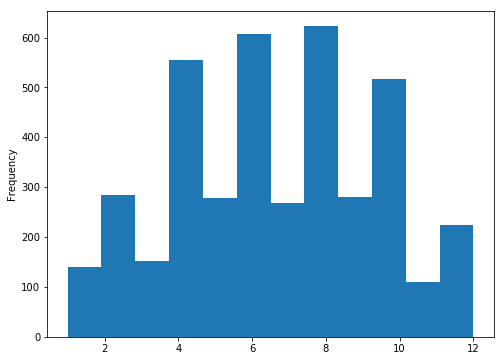

In [29]:
nitrodata['Month'].plot(kind='hist',
                        bins=12,
                        figsize=(8,6));

### Filter merged data

First we want to know how many sites are collecting data of interest. We find there are 22 sites. Of those sites, we want to know which were collecting data after the Jordan Lake Rules were passed and how much data are being collected at this site.

Based on this, we see several sites stopped collecting data prior to 2009, when the first iteration of Jordan Rules were passed. We also see that some of these sites collected only a few years of data. Remove those sites and plot the remaining sites on the map. 

In [30]:
#Tally the number of unique sites
nitrodata['MonitoringLocationIdentifier'].nunique()

22

In [31]:
#Group data by site
siteGroup = nitrodata.groupby('MonitoringLocationIdentifier')

#Compute min and max of year
siteInfo = siteGroup.agg({'Year':('min','max')})

#Rename Colummns
siteInfo.columns = ['StartYear','EndYear']

#Compute Range
siteInfo['Range'] = siteInfo['EndYear'] - siteInfo['StartYear']
siteInfo.head()

,StartYear,EndYear,Range
MonitoringLocationIdentifier,,,
USGS-0209330990,1985,1990,5
USGS-0209331325,1985,1990,5
USGS-0209437825,1985,1990,5
USGS-0209437850,1985,1990,5
USGS-02096842,1979,1981,2


In [32]:
#Limit data to those with more than 10 years data and still operating
siteInfo = siteInfo.query('Range >= 10 & EndYear >= 2017')
siteInfo

,StartYear,EndYear,Range
MonitoringLocationIdentifier,,,
USGS-02096846,1988,2017,29
USGS-0209684980,1989,2017,28
USGS-0209699999,1991,2017,26
USGS-02097464,1988,2017,29
USGS-0209749990,1988,2017,29
USGS-0209768310,1992,2017,25
USGS-0209771550,1991,2017,26
USGS-0209782609,1999,2017,18
USGS-0209799150,1991,2017,26


In [164]:
#Filter our compined table to contain only these sites
siteMask = nitrodata['MonitoringLocationIdentifier'].isin(siteInfo.index)
dfSubSites = nitrodata[siteMask]
dfSubSites.shape

(2366, 20)

In [165]:
#Group and map these sites
dfSubSites2 = df.groupby('MonitoringLocationIdentifier').first()

#Find center coordinates from medians of lat and long columns
medLat = dfSubSites2['LatitudeMeasure'].median()
medLng = dfSubSites2['LongitudeMeasure'].median()

#Create the initial map
m = folium.Map(location=[medLat,medLng],
               zoom_start=9,
               tiles='stamenterrain')

#Loop through all features and add them to the map as markers
for row in dfSubSites2.itertuples():
    #Get info for the record
    lat = row.LatitudeMeasure
    lng = row.LongitudeMeasure
    name = row.MonitoringLocationName
    #Create the marker object, adding them to the map object
    folium.CircleMarker(location=[lat,lng],
                        popup=name,
                        color='red',
                        fill=True,
                        fill_opacity=0.8,
                        radius=5,
                        stroke=False).add_to(m)
    
#Show map
m

### Plot total nitrogen over time, by year and by month, for one sites

In [166]:
#Create a list of sites
siteIDs = dfSubSites['MonitoringLocationIdentifier'].unique().tolist()
siteIDs

['USGS-02096846',
 'USGS-0209684980',
 'USGS-0209699999',
 'USGS-02097464',
 'USGS-0209749990',
 'USGS-0209768310',
 'USGS-0209771550',
 'USGS-0209782609',
 'USGS-0209799150',
 'USGS-0209801100']

In [168]:
siteID = 'USGS-02096846'
#Isolate data for the selected site
dfSite = nitrodata[nitrodata['MonitoringLocationIdentifier'] == siteID]
dfSite.head()

,OrganizationIdentifier_x,MonitoringLocationIdentifier,MonitoringLocationName,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,LatitudeMeasure,LongitudeMeasure,OrganizationIdentifier_y,ActivityStartDate,ResultDetectionConditionText,CharacteristicName,ResultSampleFractionText,ResultMeasureValue,ResultMeasure/MeasureUnitCode,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode,TotalN,Year,Month
967,USGS-NC,USGS-02096846,"CANE CREEK NEAR ORANGE GROVE, NC",7.54,sq mi,35.987222,-79.206111,USGS-NC,1989-05-23,NaN,"Nitrogen, mixed forms (NH3), (NH4), organic, (...",Total,1.0,mg/l,NaN,NaN,NaN,1.0,1989,5
968,USGS-NC,USGS-02096846,"CANE CREEK NEAR ORANGE GROVE, NC",7.54,sq mi,35.987222,-79.206111,USGS-NC,1989-05-23,NaN,"Nitrogen, mixed forms (NH3), (NH4), organic, (...",Total,4.4,mg/l NO3,NaN,NaN,NaN,4.4,1989,5
969,USGS-NC,USGS-02096846,"CANE CREEK NEAR ORANGE GROVE, NC",7.54,sq mi,35.987222,-79.206111,USGS-NC,1988-10-25,NaN,"Nitrogen, mixed forms (NH3), (NH4), organic, (...",Total,1.1,mg/l,NaN,NaN,NaN,1.1,1988,10
970,USGS-NC,USGS-02096846,"CANE CREEK NEAR ORANGE GROVE, NC",7.54,sq mi,35.987222,-79.206111,USGS-NC,1988-10-25,NaN,"Nitrogen, mixed forms (NH3), (NH4), organic, (...",Total,4.9,mg/l NO3,NaN,NaN,NaN,4.9,1988,10
971,USGS-NC,USGS-02096846,"CANE CREEK NEAR ORANGE GROVE, NC",7.54,sq mi,35.987222,-79.206111,USGS-NC,1988-11-21,NaN,"Nitrogen, mixed forms (NH3), (NH4), organic, (...",Total,1.2,mg/l,NaN,NaN,NaN,1.2,1988,11


In [169]:
#Group the data for the site on date
dateGroup = dfSite.groupby(('ActivityStartDate'))

In [155]:
#Compute mean 
dfAvgN = dateGroup.agg({'TotalN':'mean',
                        'Year':'mean',
                        'Month':'mean'
                       })
#Drop rows with null values
dfAvgN.dropna(axis='rows',how='any',inplace=True)
#Show the first 5 rows
dfAvgN.head()

,TotalN,Year,Month
ActivityStartDate,,,
1988-10-25,3.00,1988,10
1988-11-21,3.25,1988,11
1988-12-16,2.70,1988,12
1989-02-16,1.35,1989,2
1989-02-28,3.25,1989,2


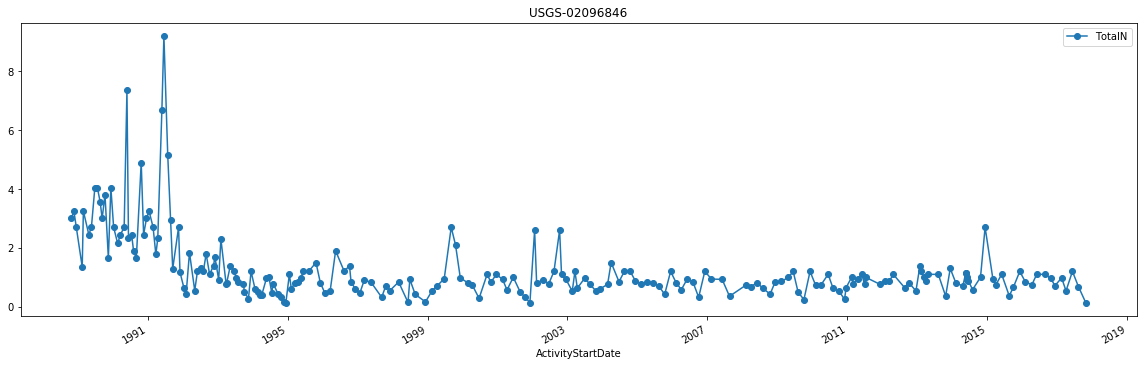

In [156]:
#Create a line plot of daily N
dfAvgN.plot(y='TotalN',
            figsize=(20,6),
            title=siteID,
            marker='o',
            by='Month');

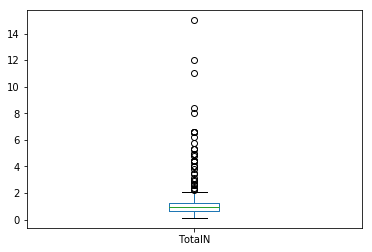

In [160]:
#Box plot by month
df["TotalN"].plot(kind='box',x='Month')

In [35]:
theSite = nitrodata.loc[0,'MonitoringLocationName']
theSite

'BROOKS LAKE TRIB NR BROWNS SUMMIT, NC'

In [36]:
#Extract records for the site
siteData = nitrodata[nitrodata['MonitoringLocationName'] == "BROOKS LAKE TRIB NR BROWNS SUMMIT, NC"]
siteData.columns

Index(['OrganizationIdentifier_x', 'MonitoringLocationIdentifier',
       'MonitoringLocationName', 'DrainageAreaMeasure/MeasureValue',
       'DrainageAreaMeasure/MeasureUnitCode', 'LatitudeMeasure',
       'LongitudeMeasure', 'OrganizationIdentifier_y', 'ActivityStartDate',
       'ResultDetectionConditionText', 'CharacteristicName',
       'ResultSampleFractionText', 'ResultMeasureValue',
       'ResultMeasure/MeasureUnitCode', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode', 'TotalN', 'Year',
       'Month'],
      dtype='object')

In [47]:
siteDataY = siteData.groupby(('MonitoringLocationName','Year'))['DetectionQuantitationLimitMeasure/MeasureValue'].mean()
siteDataY.dropna(axis='rows',inplace=True)
siteDataY.reset_index()
siteDataY.head()

MonitoringLocationName                 Year
BROOKS LAKE TRIB NR BROWNS SUMMIT, NC  1985     3.522222
                                       1986     1.350000
                                       1987     4.100000
                                       1988    10.450000
                                       1989     4.784615
Name: DetectionQuantitationLimitMeasure/MeasureValue, dtype: float64

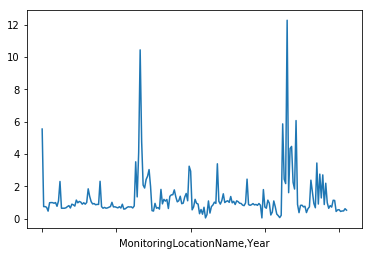

In [71]:
siteDataY.plot(x='Year')

In [87]:
siteGroup = nitrodata.groupby(('MonitoringLocationName','Year'))
S = siteGroup['DetectionQuantitationLimitMeasure/MeasureValue'].mean().reset_index()
siteData2.dropna(axis='rows',inplace=True)
siteData2.head()

,MonitoringLocationName,Year,DetectionQuantitationLimitMeasure/MeasureValue
0,"B. EVERETT JORDAN LAKE, HAW R ARM NR HANKS CHAPEL",1991,5.550
3,"B. EVERETT JORDAN LAKE, HAW R ARM NR HANKS CHAPEL",1994,0.750
4,"B. EVERETT JORDAN LAKE, HAW R ARM NR HANKS CHAPEL",1995,0.750
6,"B. EVERETT JORDAN LAKE, HAW R ARM NR HANKS CHAPEL",1997,0.705
7,"B. EVERETT JORDAN LAKE, HAW R ARM NR HANKS CHAPEL",1998,0.470


In [103]:
siteGroup = nitrodata.groupby(('MonitoringLocationName','Year'))
df3 = siteGroup['DetectionQuantitationLimitMeasure/MeasureValue'].mean().unstack(0)
df3.head()

MonitoringLocationName,"B. EVERETT JORDAN LAKE, HAW R ARM NR HANKS CHAPEL","B.E. JORDAN LAKE AB US HWY 64 AT WILSONVILLE, NC","B.E. JORDAN LK AT BELLS LANDNG NR GRIFFINS XRDS,NC","BROOKS LAKE TRIB NR BROWNS SUMMIT, NC","CANDY CR AT SR2700 NR MONTICELLO, NC","CANE CR RESERVOIR AT DAM NR WHITE CROSS, NC","CANE CREEK NEAR ORANGE GROVE, NC","CANE CREEK UPSTREAM SR1126 NR BUCKHORN, NC","HAW R BELOW B. EVERETT JORDAN DAM NR MONCURE, NC","HAW RIVER NEAR BYNUM, NC",...,"JORDAN LAKE NEAR BUOY 8 NEAR BELLS, NC","JORDAN LK, WHITE OAK CR ARM BL SR1008 AT BELLS, NC","MORGAN CREEK NEAR CHAPEL HILL, NC","MORGAN CREEK NEAR WHITE CROSS, NC","NEW HOPE CREEK NEAR BLANDS, NC","NORTHEAST CREEK AT SR1100 NR GENLEE, NC","SMITH BRANCH LOWER TRIB NR MONTICELLO, NC","SMITH BRANCH UPPER TRIB NR MONTICELLO, NC","UNIVERSITY LAKE AT INTAKES NR CHAPEL HILL, NC","WHITE OAK CR AT MOUTH NEAR GREEN LEVEL, NC"
Year,,,,,,,,,,,,,,,,,,,,,
1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


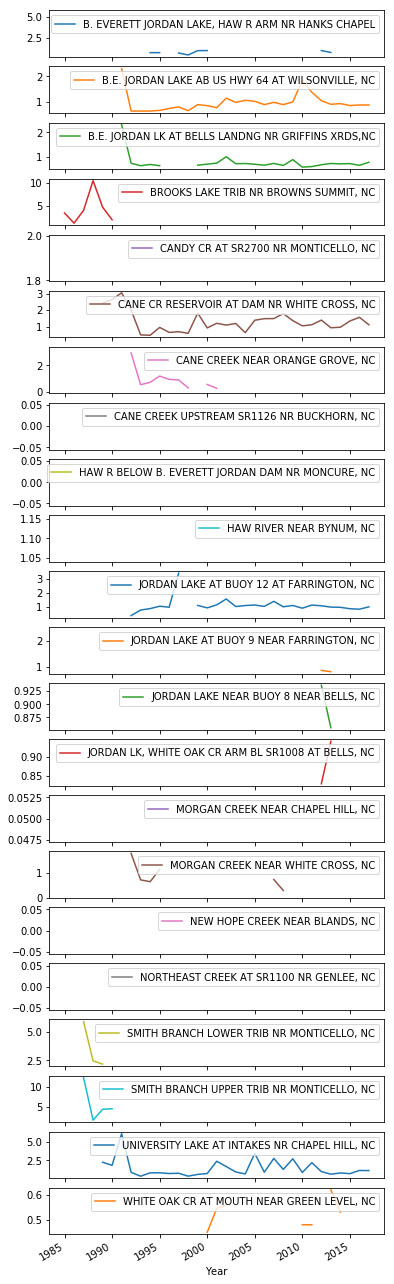

In [104]:
df3.plot(subplots='True',figsize=(6,25));

In [ ]:
siteDataY.plot(kind='line',subplots=True,x='Year',
              y='DetectionQuantitationLimitMeasure/MeasureValue');

### Plot the 2017 Nitrogen year on leaflet

## Compare the Nitrogen Load with Thresholds
The water quality data reports Nitrogen as mg/l. In order to convert to an annual load (lbs/yr), we need to know the volume of water flowing through each site. Go to the NWIS Mapper to find which USGS gauges are closest to the Haw River Arm (1 site) and the New Hope Arm (3 sites).

### Load NWIS data for Haw River

### Calculate Annual Load for Haw River

To calculate the annual load we need to convert cfs to MGD. Then we use pipes and dplyr to calculate the total annual flow at Haw River. Next, we calculate the average Nitrogen load for samples taken during each year. This is a rough proxy. A finer analysis can be undertaken by summarizing monthly flow and water quality, aggregating to the year as the last step. The annual load is then the: Total Flow * average Nitrogen * 8.34 lbs per gallon

We can then plot the annual load with the threshold of 2.567 Million pounds per year.

### Calculate Annual Load for New Hope Creek

Here there are 3 upstream gauges for New Hope Creek. We will download that information into a single file. We repeat the above analyis with the New Hope stream gauges.